In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
import cv2
import math
from itertools import product
import random

# Exercise 1: Feature points detectors

## a) The Hessian detector

#### Functions from previous exercise:

In [21]:
def gauss(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))
    g /= g.sum()
    return g.reshape((-1, 1)), x

def gaussdx(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))*-2*x/(2*sigma**2)
    g /= np.abs(g).sum()
    return g.reshape((-1, 1)), x

def nonmaxima_suppression_box(img):
    img_suppressed = img.copy()
    for (i, j), pixel_val in np.ndenumerate(img):
        neighbors = product(
            [(i-1)%img.shape[0], i, (i+1)%img.shape[0]], # % img.shape to wrap around image
            [(j-1)%img.shape[1], j, (j+1)%img.shape[1]]
        )
        for u, v in neighbors:
            if pixel_val < img[u, v]:
                img_suppressed[i, j] = 0 # not a maximum, suppress!
    return img_suppressed

def getSize(sigma): 
    return 2*math.ceil(sigma*3)+1

In [22]:
def derive2(img, sigma, ax):
    G, _ = gauss(sigma, getSize(sigma))
    D, _ = gaussdx(sigma, getSize(sigma))
    
    if ax == "x":
        return cv2.filter2D(cv2.filter2D(img, -1, -D.T), -1, G)
    if ax == "y":
    	return cv2.filter2D(cv2.filter2D(img, -1, G.T), -1, -D)
        

In [23]:
def derive(img, sigma):
    G, _ = gauss(sigma, getSize(sigma))
    D, _ = gaussdx(sigma, getSize(sigma))
    
    img_x = cv2.filter2D(cv2.filter2D(img, -1, -D.T), -1, G)
    img_y = cv2.filter2D(cv2.filter2D(img, -1, G.T), -1, -D)
    img_xx = cv2.filter2D(cv2.filter2D(img_x, -1, -D.T), -1, G)
    img_yy = cv2.filter2D(cv2.filter2D(img_y, -1, G.T), -1, -D)
    img_xy = cv2.filter2D(cv2.filter2D(img_x, -1, G.T), -1, -D)
    
    return img_x, img_y, img_xx, img_yy, img_xy

#### The result

In [24]:
def hessian_points(img_gray, sigma, threshold):
    _, _, img_xx, img_yy, img_xy = derive(img_gray, sigma)
    
    H_det = (img_xx * img_yy - img_xy ** 2) # * sigma**4
    H_det_s = nonmaxima_suppression_box(H_det)
    points = np.argwhere(H_det_s > threshold)
    return H_det, points
    

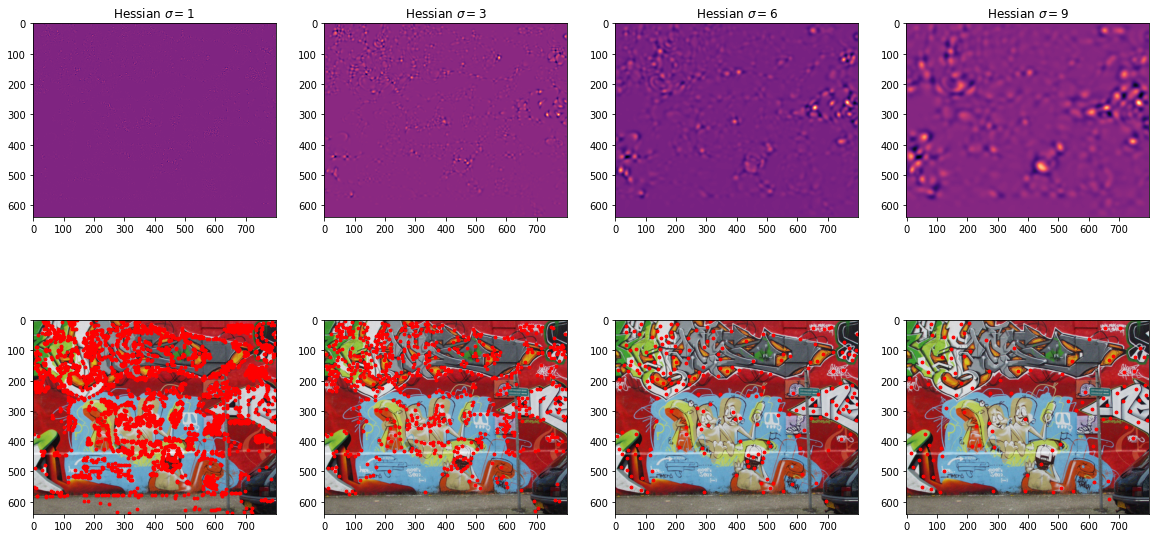

In [25]:
test_points = cv2.cvtColor(cv2.imread('data/graf/graf1.jpg'), cv2.COLOR_BGR2RGB)
test_points_gray = cv2.cvtColor(test_points, cv2.COLOR_RGB2GRAY).astype('float64')

plt.figure(figsize=(20,10))
sigmas = [1, 3, 6, 9]
for i, sigma in enumerate(sigmas):
    plt.subplot(2, len(sigmas), i+1)
    H_det, points = hessian_points(test_points_gray, sigma, 100)
    plt.title(f"Hessian $\sigma = {sigma}$")
    plt.imshow(H_det, cmap="magma")
    plt.subplot(2, len(sigmas), len(sigmas)+i+1)
    plt.imshow(test_points)
    plt.scatter(points[:,1], points[:,0], s=8, c='r')

__*Question:*__ What kind of structures in the image are detected by the algorithm?
How does the parameter $\sigma$ affect the result?

> The corners

##  b) Harris feature point detector

In [26]:
def harris_points(img_gray, sigma, threshold):
    sigma_ = sigma*1.6
    alpha = 0.06
    img_x, img_y, img_xx, img_yy, img_xy = derive(img_gray, sigma)
    G, _ = gauss(sigma_, getSize(sigma_))
    C_11 = cv2.filter2D(cv2.filter2D(img_x**2, -1, G), -1, G.T) * sigma**2
    C_22 = cv2.filter2D(cv2.filter2D(img_y**2, -1, G), -1, G.T) * sigma**2
    C_21 = cv2.filter2D(cv2.filter2D(img_x * img_y, -1, G), -1, G.T) * sigma**2
    
    C_det = (C_11 * C_22 - C_21 ** 2)
    C_tr = C_11 + C_22
    
    r = C_det - alpha * C_tr**2
    points = np.argwhere(nonmaxima_suppression_box(r) > threshold)
    return r, points

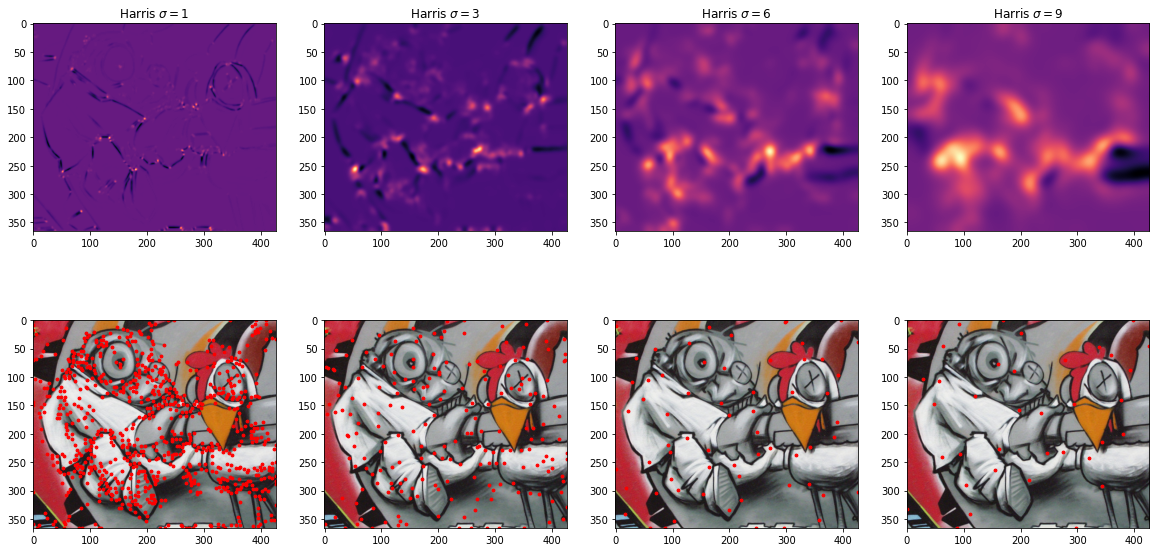

In [27]:
test_points = cv2.cvtColor(cv2.imread('data/test_points.jpg'), cv2.COLOR_BGR2RGB)
test_points_gray = cv2.cvtColor(test_points, cv2.COLOR_RGB2GRAY).astype('float64')

plt.figure(figsize=(20,10))
sigmas = [1, 3, 6, 9]
for i, sigma in enumerate(sigmas):
    plt.subplot(2, len(sigmas), i+1)
    H_det, points = harris_points(test_points_gray, sigma, 100)
    plt.title(f"Harris $\sigma = {sigma}$")
    plt.imshow(H_det, cmap="magma")
    plt.subplot(2, len(sigmas), len(sigmas)+i+1)
    plt.imshow(test_points)
    plt.scatter(points[:,1], points[:,0], s=8, c='r')

# Exercise 2: Matching local regions

## a) Find correspondences

In [28]:
def simple_descriptors(I, pts, bins=16, radius=40, w=11):

	g, _ = gauss(w, getSize(w))
	d, _ = gaussdx(w, getSize(w))

	Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
	Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

	Iy = cv2.filter2D(I, cv2.CV_32F, g)
	Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

	Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
	Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

	Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
	Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

	mag = np.sqrt(Ix**2+Iy**2)
	mag = np.floor(mag*((bins-1)/np.max(mag)))

	feat = Ixx+Iyy
	feat+=abs(np.min(feat))
	feat = np.floor(feat*((bins-1)/np.max(feat)))

	desc = []

	for x,y in pts:
		minx = max(x-radius, 0)
		maxx = min(x+radius, I.shape[0])
		miny = max(y-radius, 0)
		maxy = min(y+radius, I.shape[1])
		r1 = mag[minx:maxx, miny:maxy].reshape(-1)
		r2 = feat[minx:maxx, miny:maxy].reshape(-1)
	
		a = np.zeros((bins,bins))
		for m, l in zip(r1,r2):
			a[int(m),int(l)]+=1

		a=a.reshape(-1)
		a/=np.sum(a)

		desc.append(a)

	return np.array(desc)


In [29]:
def find_correspondences(descriptors1, descriptors2):
    indices_map = []
    ds = []
    for hist1 in descriptors1:
        d = np.sqrt(np.sum((np.sqrt(hist1) - np.sqrt(descriptors2))**2, axis=1)/2)
        indices_map.append(np.argwhere(d == np.min(d))[0][0])
        ds.append(np.min(d))
        
    return indices_map, ds

## b) Visualize correspondences

In [30]:
def display_matches(im1, im2, pts1, pts2, matches):

	# NOTE: this will only work correctly for images with the same height
	# NOTE: matches should contain index pairs (i.e. first element is the index to pts1 and second for pts2)

	I = np.hstack((im1,im2))
	w = im1.shape[1]
	
	plt.imshow(I, cmap="gray")

	for i, j in matches:
		p1 = pts1[int(i)]
		p2 = pts2[int(j)]
		plt.plot(p1[1], p1[0], 'bo')
		plt.plot(p2[1]+w, p2[0], 'bo')
		plt.plot([p1[1], p2[1]+w], [p1[0], p2[0]], 'lime')

	plt.draw()

In [31]:
graf1 = cv2.cvtColor(cv2.imread('data/graf/graf1.jpg'), cv2.COLOR_BGR2RGB)
graf1_gray = cv2.cvtColor(graf1, cv2.COLOR_RGB2GRAY).astype('float64')
graf2 = cv2.cvtColor(cv2.imread('data/graf/graf2.jpg'), cv2.COLOR_BGR2RGB)
graf2_gray = cv2.cvtColor(graf2, cv2.COLOR_RGB2GRAY).astype('float64')

_, list1 = harris_points(graf1_gray, 9, 500)
_, list2 = harris_points(graf2_gray, 9, 500)

In [32]:
descriptors1 = simple_descriptors(graf1, list1)
descriptors2 = simple_descriptors(graf2, list2)

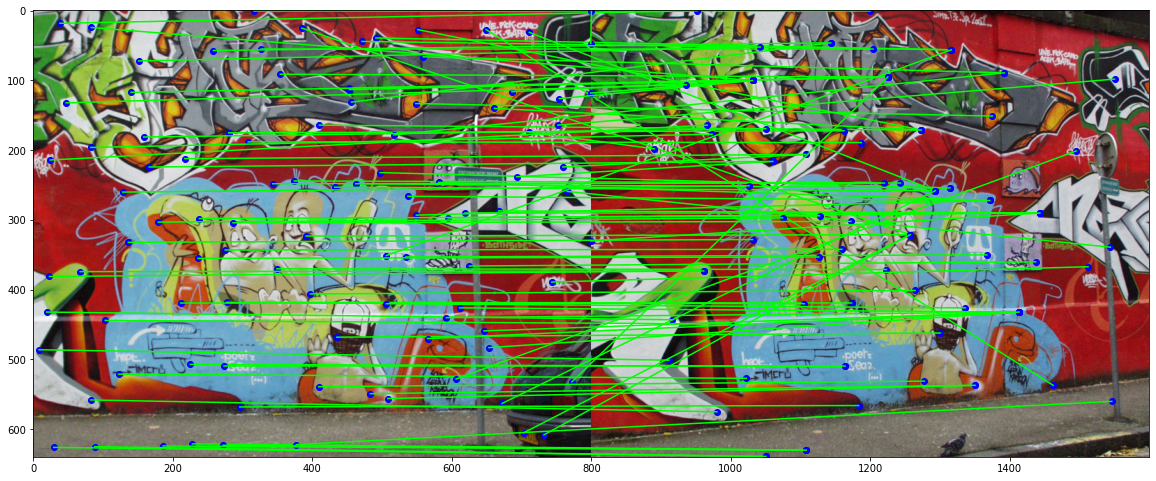

In [33]:
indices_map, dist = find_correspondences(descriptors1, descriptors2)
plt.figure(figsize=(20, 10))
display_matches(graf1, graf2, list1, list2, zip(range(len(list1)), indices_map))

## c) Implement a simple feature point matching algorithm

In [35]:
def find_matches(img1, img2, sort=False):
    _, list1 = harris_points(img1, 6, 500)
    _, list2 = harris_points(img2, 6, 500)
    
    random.shuffle(list2)
    
    descriptors1 = simple_descriptors(img1, list1, bins=32, radius=40, w=11)
    descriptors2 = simple_descriptors(img2, list2, bins=32, radius=40, w=11)
    
    pairs = []
    indices_map1, dist1 = find_correspondences(descriptors1, descriptors2)
    indices_map2, dist2 = find_correspondences(descriptors2, descriptors1)

    for i, j in enumerate(indices_map1):
        if(indices_map2[j] == i):
            pairs.append((i, j, dist1[i]+dist2[j]))
            
    if sort: pairs.sort(key=lambda x: x[2])
    
    return [(i,j) for i, j, _ in pairs], list1, list2

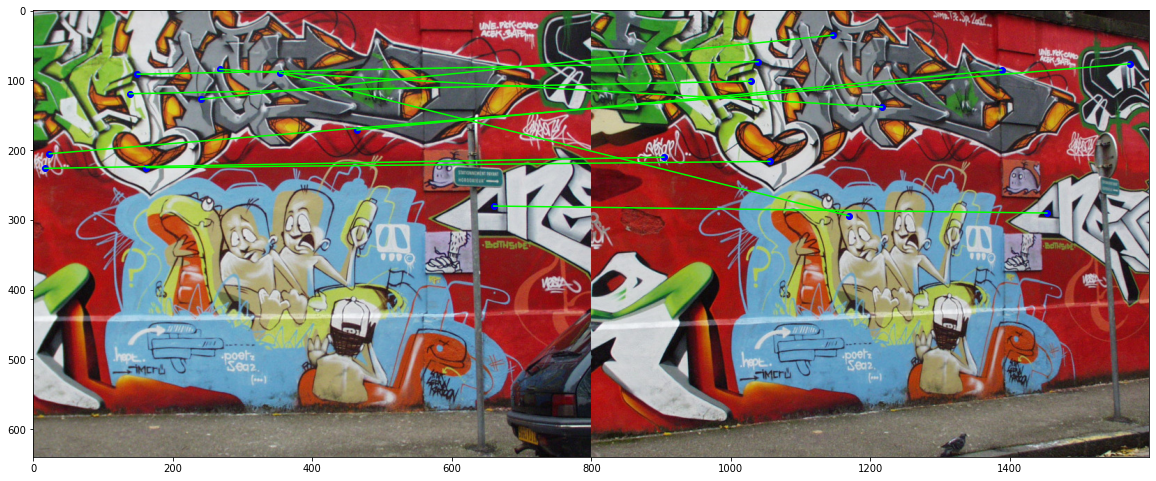

In [47]:
graf1 = cv2.cvtColor(cv2.imread('data/graf/graf1.jpg'), cv2.COLOR_BGR2RGB)
graf1_gray = cv2.cvtColor(graf1, cv2.COLOR_RGB2GRAY).astype('float64')
graf2 = cv2.cvtColor(cv2.imread('data/graf/graf2.jpg'), cv2.COLOR_BGR2RGB)
graf2_gray = cv2.cvtColor(graf2, cv2.COLOR_RGB2GRAY).astype('float64')

pairs, list1, list2 = find_matches(graf1_gray, graf2_gray, sort=True)

plt.figure(figsize=(20, 10))
display_matches(graf1, graf2, list1, list2, pairs[:10])

## d) Eliminating incorrect matches

In [43]:
def find_second_correspondences(descriptors1, descriptors2):
    indices_map = []
    ds = []
    for hist1 in descriptors1:
        d = np.sqrt(np.sum((np.sqrt(hist1) - np.sqrt(descriptors2))**2, axis=1)/2)
        # remove the smallest element
        d[np.argmin(d)] = np.inf
        indices_map.append(np.argwhere(d == np.min(d))[0][0])
        ds.append(np.min(d))
        
    return indices_map, ds

In [44]:
def find_matches_ratio(img1, img2, threshold=0.8, sort=False):
    _, list1 = harris_points(img1, 6, 500)
    _, list2 = harris_points(img2, 6, 500)
    
    random.shuffle(list2)
    
    descriptors1 = simple_descriptors(img1, list1, bins=32, radius=40, w=11)
    descriptors2 = simple_descriptors(img2, list2, bins=32, radius=40, w=11)
    
    pairs = []
    indices_map1, dist1 = find_correspondences(descriptors1, descriptors2)
    second_indices_map1, second_dist1 = find_second_correspondences(descriptors1, descriptors2)
    indices_map2, dist2 = find_correspondences(descriptors2, descriptors1)
    second_indices_map2, second_dist2 = find_second_correspondences(descriptors2, descriptors1)

    for i, j in enumerate(indices_map1):
        if(indices_map2[j] == i):
            ratio = (second_dist1[i]+second_dist2[j]) / (dist1[i]+dist2[j])
            if ratio > threshold:
                pairs.append((i, j, dist1[i]+dist2[j]))
            
    if sort: pairs.sort(key=lambda x: x[2])
    
    return [(i,j) for i, j, _ in pairs], list1, list2

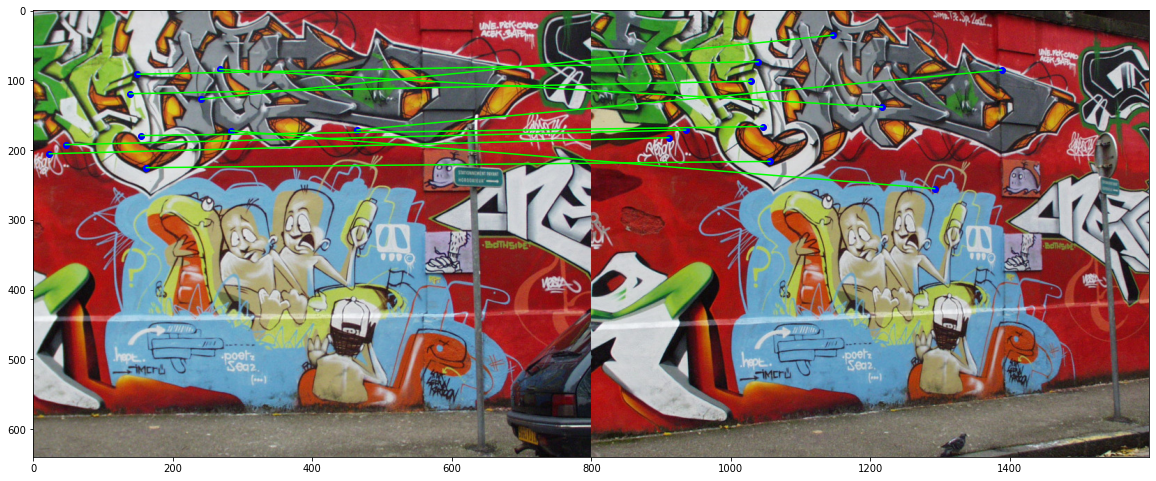

In [46]:
graf1 = cv2.cvtColor(cv2.imread('data/graf/graf1.jpg'), cv2.COLOR_BGR2RGB)
graf1_gray = cv2.cvtColor(graf1, cv2.COLOR_RGB2GRAY).astype('float64')
graf2 = cv2.cvtColor(cv2.imread('data/graf/graf2.jpg'), cv2.COLOR_BGR2RGB)
graf2_gray = cv2.cvtColor(graf2, cv2.COLOR_RGB2GRAY).astype('float64')

pairs, list1, list2 = find_matches_ratio(graf1_gray, graf2_gray, sort=True)

plt.figure(figsize=(20, 10))
display_matches(graf1, graf2, list1, list2, pairs[:10])

## f) Keypoints on video

In [8]:
fast = cv2.FastFeatureDetector_create()
fast.setNonmaxSuppression(10)
fast.setThreshold(20)

video = cv2.VideoCapture("data/video.mp4")

while video.isOpened():
    ret, frame = video.read()
    if ret == True:
        key_points = fast.detect(frame, None)
        cv2.imshow('video', cv2.drawKeypoints(frame, key_points, frame))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

video.release()
cv2.destroyAllWindows()

# Exercise 3: Homography estimation

## a) Write a function `estimate_homography`

In [255]:
def estimate_homography(points_r, points_t):
    A = []
    for (x_r, y_r), (x_t, y_t) in zip(points_r, points_t):
        A.append([x_r, y_r, 1, 0, 0, 0, -x_t * x_r, -x_t * y_r, -x_t])
        A.append([0, 0, 0, x_r, y_r, 1, -y_t * x_r, -y_t * y_r, -y_t])
    A = np.array(A)
    
    U, S, V = np.linalg.svd(A)
    H = V[-1]
    H = H / H[-1]
    return H.reshape((3,3))

## b) New York

In [1]:
newyork1 = cv2.cvtColor(cv2.imread('data/newyork/newyork1.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
newyork2 = cv2.cvtColor(cv2.imread('data/newyork/newyork2.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')

NameError: name 'cv2' is not defined

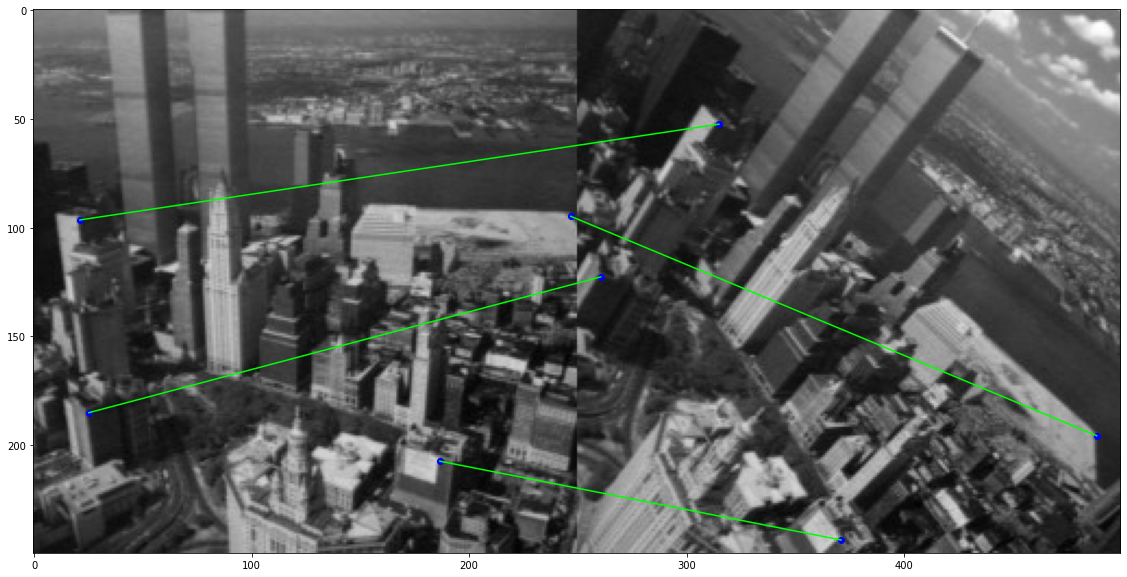

In [237]:
f = open("data/newyork/newyork.txt", "r")
hand_annotated = np.array(f.read().split()).reshape((4,4)).astype('float')
ha_points_1, ha_points_2 = hand_annotated[:,1::-1], hand_annotated[:,4:1:-1]
plt.figure(figsize=(20, 10))
display_matches(newyork1, newyork2, ha_points_1, ha_points_2, [(i,i) for i in range(4)])

(Text(0.5, 1.0, 'NewYork1 - warp'),
 <matplotlib.image.AxesImage at 0x1ec96c5a370>)

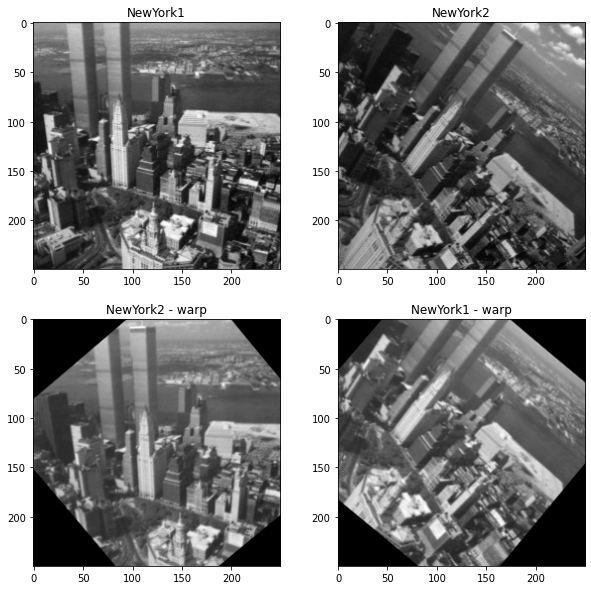

In [268]:

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("NewYork1"), plt.imshow(newyork1, cmap="gray")
plt.subplot(2,2,2)
plt.title("NewYork2"), plt.imshow(newyork2, cmap="gray")
plt.subplot(2,2,3)
H = estimate_homography(ha_points_1, ha_points_2)
newyork2_warp = cv2.warpPerspective(newyork2, H, dsize=newyork1.shape)
plt.title("NewYork2 - warp"), plt.imshow(newyork2_warp, cmap="gray")
plt.subplot(2,2,4)
H = estimate_homography(ha_points_2, ha_points_1)
newyork1_warp = cv2.warpPerspective(newyork1, H, dsize=newyork2.shape)
plt.title("NewYork1 - warp"), plt.imshow(newyork1_warp, cmap="gray")

## c) Putting it all together

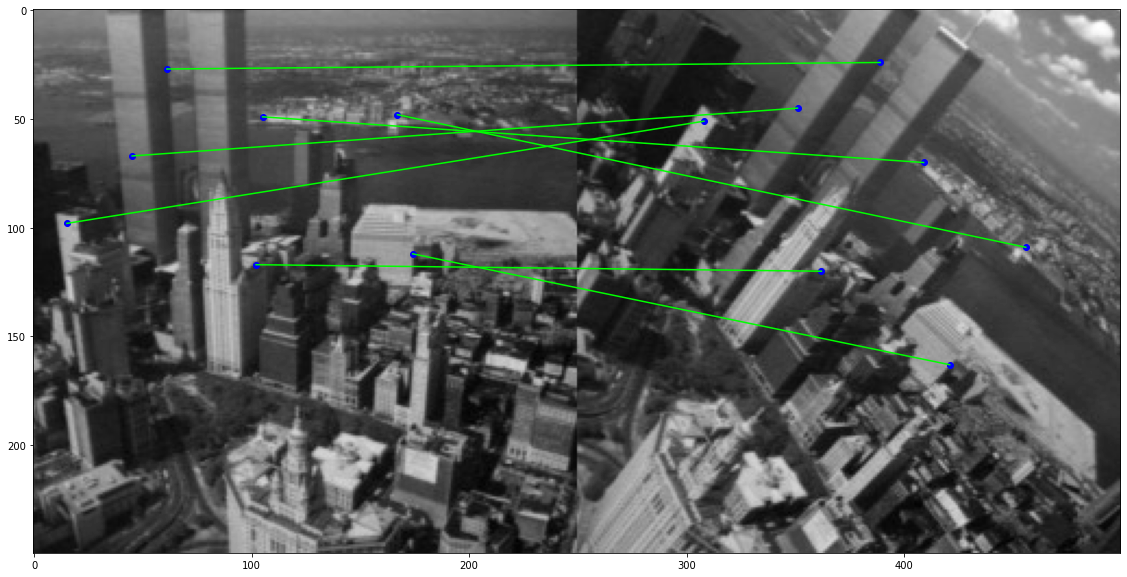

In [424]:
pairs, list1, list2 = find_matches(newyork1, newyork2, sort=True)
pairs = np.array(pairs[:10])
list1 = np.array(list1)
list2 = np.array(list2)
points_1 = list1[pairs[:,0]]
points_2 = list2[pairs[:,1]]

plt.figure(figsize=(20, 10))
display_matches(newyork1, newyork2, list1, list2, pairs)


(Text(0.5, 1.0, 'NewYork1 - warp'),
 <matplotlib.image.AxesImage at 0x1ecb254b250>)

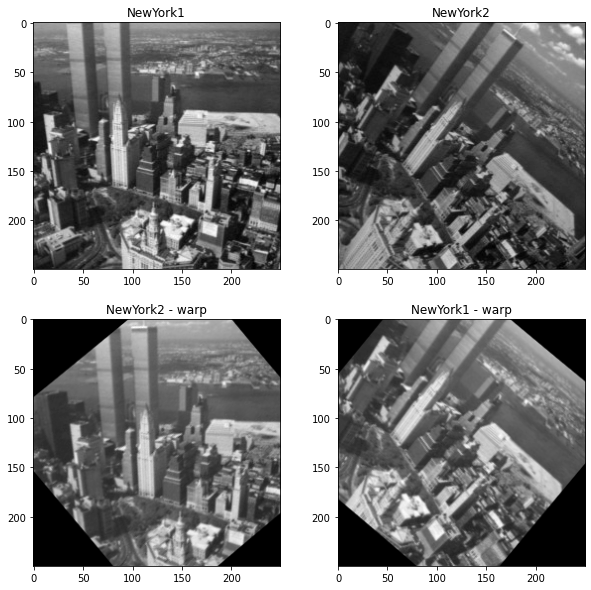

In [425]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("NewYork1"), plt.imshow(newyork1, cmap="gray")
plt.subplot(2,2,2)
plt.title("NewYork2"), plt.imshow(newyork2, cmap="gray")
plt.subplot(2,2,3)
H = estimate_homography(points_1, points_2)
newyork2_warp = cv2.warpPerspective(newyork2, H, dsize=newyork1.shape)
plt.title("NewYork2 - warp"), plt.imshow(newyork2_warp, cmap="gray")
plt.subplot(2,2,4)
H = estimate_homography(points_2, points_1)
newyork1_warp = cv2.warpPerspective(newyork1, H, dsize=newyork2.shape)
plt.title("NewYork1 - warp"), plt.imshow(newyork1_warp, cmap="gray")

 ## e)  Write your own function for mapping points using the homography matrix

In [446]:
def myWarpPerspective(img, H):
    res = np.zeros_like(img)
    Hinv = np.linalg.inv(H)
    for (y_r, x_r), v in np.ndenumerate(res):
        r = np.array([x_r, y_r, 1])
        t = Hinv.dot(r)
        t = t/t[-1]
        x_t, y_t = round(t[0]), round(t[1])
        if(x_t >= 0 and x_t < img.shape[1] and y_t >= 0 and y_t < img.shape[0]):
            res[y_r, x_r] = img[y_t, x_t]
        
    return res

(Text(0.5, 1.0, 'NewYork1 - warp'),
 <matplotlib.image.AxesImage at 0x1ecb3365040>)

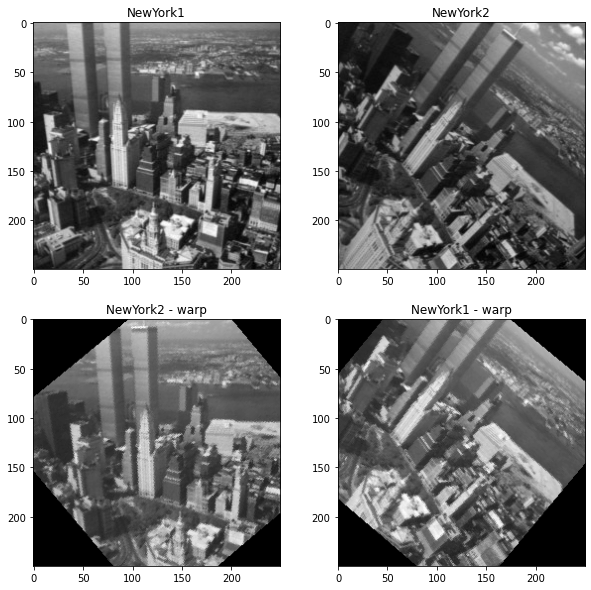

In [447]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("NewYork1"), plt.imshow(newyork1, cmap="gray")
plt.subplot(2,2,2)
plt.title("NewYork2"), plt.imshow(newyork2, cmap="gray")
plt.subplot(2,2,3)
H = estimate_homography(points_1, points_2)
newyork2_warp = myWarpPerspective(newyork2, H)
plt.title("NewYork2 - warp"), plt.imshow(newyork2_warp, cmap="gray")
plt.subplot(2,2,4)
H = estimate_homography(points_2, points_1)
newyork1_warp = myWarpPerspective(newyork1, H)
plt.title("NewYork1 - warp"), plt.imshow(newyork1_warp, cmap="gray")